In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/man-juu/datasetML/main/dataset_language_detection.csv")
data.head(10)

,Text,Language
0,في أبريل م قدم الزعيم مصطفى النحاس مذكرة للسف...,Arabic
1,在演说中，他呼吁全人类团结起来，共同反对专制、贫困、疾病和战争，他在演说中提到的：“不要问你...,Chinese
2,francisco de miranda is een gemeente in de ven...,Dutch
3,oyama station was opened on april the statio...,English
4,elle est la fille de gérios tuéni et katbé sur...,French
5,यी की अपनी चित्रलिपि पर आधारित एक लिपि है जिसम...,Hindi
6,artemisina plumosa adalah spesies spons yang t...,Indonesian
7,通称「モモ」。年組の女子生徒。お下げ髪にぽっちゃりした感じの顔つきが特徴（スズとは「ポッチャ...,Japanese
8,보건복지부 내부에서도 일단 환영 입장이다 행정부 내에서 보건복지부의 위상을 높일 수...,Korean
9,"un ""compilateur"" témoin de son temps appien...",Latin


Languages in dataset:

In [ ]:
data["Language"].value_counts()

Arabic        317
Latin         317
Thai          317
Swedish       317
Spanish       317
Russian       317
Romanian      317
Portugese     317
Korean        317
Chinese       317
Japanese      317
Indonesian    317
Hindi         317
French        317
English       317
Dutch         317
Turkish       317
Name: Language, dtype: int64

In [ ]:
X = data["Text"]
y = data["Language"]
languages = set(data['Language'])

## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Text Preprocessing

In [ ]:
import re
# creating a list for appending the preprocessed text
data_list = []
# iterating through all the text
for x in X:
       # removing the numbers
        x = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', x)
        # converting the text to lower case
        x = x.lower()
        #remove mentions
        x = re.sub('@\S+' , ' ' , x)
        #remove url
        x = re.sub('https*\S+' , ' ' , x)
        #remove hastag
        x= re.sub('#\S+' , ' ' , x)
        # appending to data_list
        data_list.append(x)

### Text to Vector

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(data_list).toarray()
features = cv.get_feature_names()
X.shape

(5389, 89930)

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

Getting Relevant Chars 

In [ ]:
class MultiNB:
  def __init__(self,alpha=1):
    self.alpha = alpha
    
  def _prior(self):
    P = np.zeros((self.n_classes_))
    _, self.dist = np.unique(self.y,return_counts=True)
    for i in range(self.classes_.shape[0]):
        P[i] = self.dist[i] / self.n_samples
    return P
    

  def fit(self, X, y):
    self.X = X
    self.y = y
    self.n_samples, self.n_features = X.shape
    self.classes_ = np.unique(y)
    self.n_classes_ = self.classes_.shape[0]
    self.class_priors_ = self._prior()
    
    self.uniques = []
    for i in range(self.n_features):
        tmp = np.unique(X[:,i])
        self.uniques.append( tmp )
        
    self.N_yi = np.zeros((self.n_classes_, self.n_features))
    self.N_y = np.zeros((self.n_classes_)) 
    for i in self.classes_:
        indices = np.argwhere(self.y==i).flatten()
        columnwise_sum = []
        for j in range(self.n_features):
            columnwise_sum.append(np.sum(X[indices,j]))
            
        self.N_yi[i] = columnwise_sum
        self.N_y[i] = np.sum(columnwise_sum)
    

  def _theta(self, x_i, i, h):
    Nyi = self.N_yi[h,i]
    Ny  = self.N_y[h]
    
    numerator = Nyi + self.alpha
    denominator = Ny + (self.alpha * self.n_features)
    
    return  (numerator / denominator)**x_i
  

  def _likelyhood(self, x, h):
    tmp = []
    for i in range(x.shape[0]):
        tmp.append(self._theta(x[i], i,h))
    
    return np.prod(tmp)
  

  def predict(self, X):
    samples, features = X.shape
    self.predict_proba = np.zeros((samples,self.n_classes_))
    
    for i in range(X.shape[0]):
        joint_likelyhood = np.zeros((self.n_classes_))
        
        for h in range(self.n_classes_):
            joint_likelyhood[h]  = self.class_priors_[h] * self._likelyhood(X[i],h)
            
        denominator = np.sum(joint_likelyhood)
        
        for h in range(self.n_classes_):
            numerator = joint_likelyhood[h]
            self.predict_proba[i,h] = (numerator / denominator)
        
    indices = np.argmax(self.predict_proba,axis=1)
    return self.classes_[indices]

In [ ]:
model = MultiNB()
model.fit(x_train, y_train)

y_pred_test = model.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ac_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print("Test Accuracy is :",ac_test)

Test Accuracy is : 0.7504638218923934


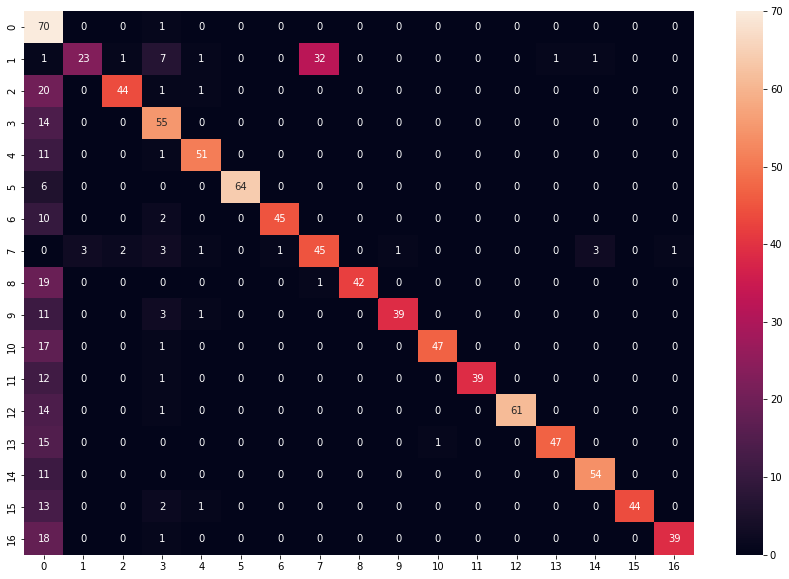

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(cm_test, annot = True)
plt.show()

In [ ]:
def predict(text):
     x = cv.transform([text]).toarray() # converting text to bag of words model (Vector)
     lang = model.predict(x)
     lang = le.inverse_transform(lang) # finding the language corresponding the the predicted value
     print("The langauge is in",lang[0]) # printing the language

In [ ]:
predict("Where is this? Who am I?")

The langauge is in English


In [ ]:
predict("أين هذا من أنا؟")

The langauge is in Arabic


In [ ]:
predict("Donde es esto ¿Quién soy yo?")

The langauge is in Spanish


In [ ]:
predict("Dimana ini Siapa aku?")

The langauge is in Indonesian


In [ ]:
predict("ここどこ?私は誰?")

The langauge is in Japanese


In [ ]:
predict("Ubi est, quis sum?")

The langauge is in Latin


In [ ]:
predict("ที่นี่ที่ไหน ฉันเป็นใคร")

The langauge is in Thai


In [ ]:
predict("Где это?Кто я?")

The langauge is in Russian


In [ ]:
predict("여기가 어디야? 나는 누구인가?")

The langauge is in Korean


In [ ]:
#text = input("Input Sentence: ")
#predict(text)